In [85]:


%load_ext pretty_jupyter

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import country_converter as coco
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import plotly.express as px

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# Examining Gains in Life Expectancy in Africa
[//]: # (-.- .tabset)

## Data Provenance

### Life Expectancy (1770 - 2021)
*Challenge Dataset*

In [66]:
#load inital dataset
raw = pd.read_csv("life-expectancy.csv")

#define entity categories
continent = ['Africa', 'Asia', 'Europe', 'Americas', 'Oceania']
income_groups = ['High-income countries', 'Upper-middle-income countries', 'Middle-income countries', 'Lower-middle-income countries', 'Low-income countries', 'No income group available']
development = ['More developed regions', 'Small Island Developing States (SIDS)', 'Less developed regions', 'Less developed regions, excluding China', 'Less developed regions, excluding least developed countries', 'Least developed countries', 'Land-locked Developing Countries (LLDC)']

#create new df for continents, income level, development status
continents = raw[raw['Entity'].isin(continent) == True]
income = raw[raw['Entity'].isin(income_groups) == True]
develop = raw[raw['Entity'].isin(development) == True]

#create new df for countries
countries = raw[raw['Entity'].isin(development) == False]
countries = countries[countries['Entity'].isin(income_groups) == False]
countries = countries[countries['Entity'].isin(continent) == False]

#add continent column for countries df
converter = coco.CountryConverter()
countries['Continent'] = converter.convert(names=countries['Code'], src="ISO3", to="continent")

#find countries without continent match - all European countries
a = countries[countries['Code'].isna() == True]
a = a[['Entity', 'Code']]
grouped = a.groupby(by="Entity").sum()

#update continent column
countries['Continent'] = countries['Continent'].str.replace('not found', 'Europe')

nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not fo

### Disease Mortality Rates (2010 - 2021)
*Institute for Health Metrics and Evaluation (IHME). Global Burden of Disease Study 2021 (GBD
2021) Cause-Specific Mortality 1990-2021. Seattle, United States of America: Institute for Health
Metrics and Evaluation (IHME), 2024.*

In [206]:
# load dataset
disease = pd.read_excel("disease-mortality-rates.XLSX")

#create a subset with only mortality rate per 100,000 people
disease = disease[['location_type', 'location_name', 'cause_name', '2010 (ASMR)', '2019 (ASMR)', '2020 (ASMR)', '2021 (ASMR)']]

#convert columns to numeric
cols = ['2010 (ASMR)', '2019 (ASMR)', '2020 (ASMR)', '2021 (ASMR)']
for i in cols:
    disease[i] = disease.loc[:, i].str.replace(r"\(.*\)","", regex=True)
    disease[i] = pd.to_numeric(disease.loc[:, i])
    
#create column for change from 2010 to 2021
disease.loc[:, 'change'] = (disease.loc[:, '2021 (ASMR)'] - disease.loc[:, '2010 (ASMR)'])

#create global dataset
globe = disease[disease['location_type'] == 'Global']

#create global grouped dataset by cause
globe_group = globe[['cause_name', '2010 (ASMR)', '2019 (ASMR)', '2020 (ASMR)', '2021 (ASMR)', 'change']].groupby(by='cause_name').mean().reset_index()

#create africa dataset
a = ['North Africa and Middle East', 'Central Sub-Saharan Africa', 'Eastern Sub-Saharan Africa', 'Southern Sub-Saharan Africa', 'Western Sub-Saharan Africa']
africa = disease[(disease['location_type'] == 'Region') & (disease['location_name'].isin(a) == True)]

#create grouped africa dataset by cause
ac = africa.copy()
ac = ac[['cause_name', '2010 (ASMR)', '2019 (ASMR)', '2020 (ASMR)', '2021 (ASMR)', 'change']]
africa_group = ac.groupby(by='cause_name').mean().reset_index()

#create column of difference between african vs global average in 2021
africa_group['diff'] = (africa_group['2021 (ASMR)'] - globe_group['2021 (ASMR)'])
africa_group = africa_group.sort_values(by='diff', ascending=False)

### Life Expectancy Decomposition (1990 - 2021)
*Institute for Health Metrics and Evaluation (IHME). Global Burden of Disease Study 2021 (GBD
2021) Cause-Specific Mortality 1990-2021. Seattle, United States of America: Institute for Health
Metrics and Evaluation (IHME), 2024.*

In [34]:
#load dataset
decomp = pd.read_excel("life-expectancy-decomp.XLSX")

#create africa df
af = ['Western Sub-Saharan Africa', 'North Africa and Middle East', 'Central Sub-Saharan Africa', 'Southern Sub-Saharan Africa', 'Eastern Sub-Saharan Africa']
decomp_africa = decomp[decomp['Location Name'].isin(af) == True]

#filter 1990-2021 only
decomp_africa = decomp_africa[(decomp_africa['Start Year'] == 1990) & (decomp_africa['End Year'] == 2021)]
decomp_africa = decomp_africa.drop(axis=0, index=670)

### Death in Armed Conflicts (1989 - 2022)
*Uppsala Conflict Data Program (2023); Natural Earth (2022) – processed by Our World in Data*

In [209]:
#load df
conflict = pd.read_csv("deaths-in-armed-conflicts.csv")

### Healthcare Expenditure (2000 - 2021)
*World Health Organization Global Health Expenditure database ( apps.who.int/nha/database ). The data was retrieved on April 15, 2024.*

In [42]:
expense = pd.read_csv("health-expenditure.csv")

### GDP
*World Bank national accounts data, and OECD National Accounts data files.*

In [49]:
#load df
gdp = pd.read_csv("gdp.csv")
gdp = gdp.dropna()

#create country code column
converter = coco.CountryConverter()
gdp['iso_a3'] = converter.convert(names=gdp['Country '], to="ISO3")

Africa Eastern and Southern not found in regex
Africa Western and Central not found in regex
Arab World not found in regex
Caribbean small states not found in regex
Central Europe and the Baltics not found in regex
Early-demographic dividend not found in regex
East Asia & Pacific not found in regex
East Asia & Pacific ( not found in regex
East Asia & Pacific (IDA & IBRD countries) not found in regex
Euro area not found in regex
Europe & Central Asia not found in regex
Europe & Central Asia ( not found in regex
Europe & Central Asia (IDA & IBRD countries) not found in regex
European Union not found in regex
Fragile and conflict affected situations not found in regex
Heavily indebted poor countries (HIPC) not found in regex
High income not found in regex
IBRD only not found in regex
IDA & IBRD total not found in regex
IDA blend not found in regex
IDA only not found in regex
IDA total not found in regex
Late-demographic dividend not found in regex
Latin America & Caribbean not found in re

In [53]:
#check which ones were missed - only regions, all country codes found
#gdp[gdp['iso_a3'] == 'not found']

## Introduction

#### ***Introduction***

This report aims to deepen understanding of how Life Expectancy in Africa has increased over time, compared to global trends. To begin, we will look at the Life Expectancy over time for each continent.

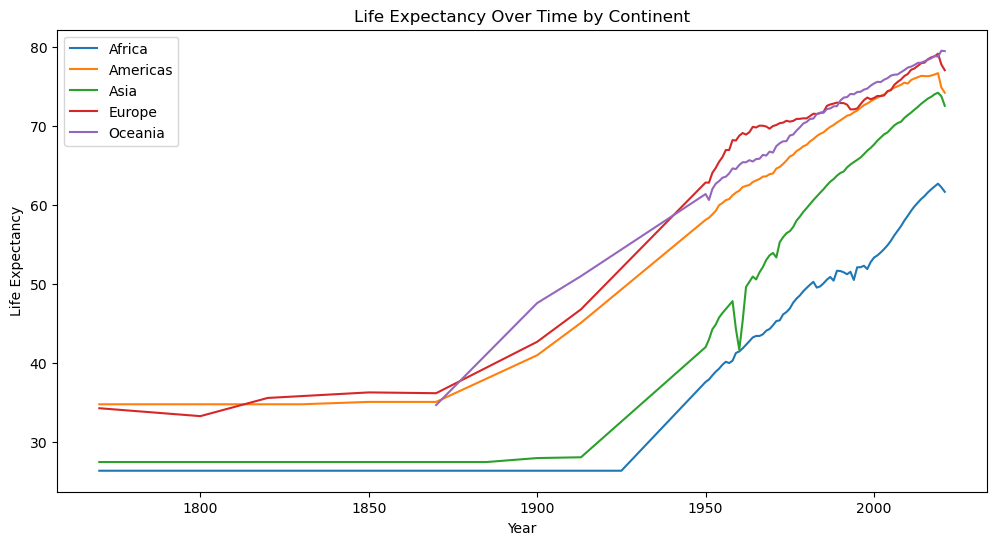

In [67]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=continents, x='Year', y='Period life expectancy at birth - Sex: all - Age: 0', hue='Entity')
plt.title('Life Expectancy Over Time by Continent')
plt.xlabel('Year')
plt.ylabel('Life Expectancy')
plt.legend()
plt.show()

Life Expectancy globally seemingly flatlined from 1770 to 1870, then Europe, Oceania and the Americas begin to rapidly rise. It is important to note that data before 1950 is very sparse, so while it looks like the rise began in 1870, it could have started in the 30 years between 1870 and 1900. Regardless, the rise corresponds well with Louis Pasteur's development of Germ Theory in the 1860's, and his later developments of vaccines for Anthrax, Foul Cholera and Rabies (1). It seems that these revolutionary discoveries laid groundwork for a continuous development of modern medicine, and thus improving life expectancy.

However, Asia and Africa don't begin to rise until around 1913 and 1925. In this report's exploration of ***Historical Context***, we will examine *why Africa's Life Expectancy lagged for that period of 55 years, and how it rose*. We will then examine *why there is currently such a gap between Africa and other continents* in the ***Contemporary Context*** and ***Disease Analysis*** sections.

### ***Sources***

1. https://library.uab.edu/locations/reynolds/collections/medical-greats/louis-pasteur

## Historical Context

### ***Historical Context***

Up until the 1950's, Africa was largely under colonial rule where medical infrastructure was scant, and often not available to the Indigenous people. Where it was developed, it was intended for the European settlers, so the power of newly developed medicines were not distributed well within Africa. Going into the 19th century, medical infrastures expand rapidly bringing gains in Life Expectancy, but they remain to be built for European settlers and such access is still not at the standard as other continents. (1)

Following on from World War II, from 1950 to 1975, the process of decolonisation begins. For some countries (like Botswana, Cape Verde, Mali) it is a slow and steady rise in Life Expectancy, where others (like Cameroon, South Sudan, Ethiopia) fluctuate greatly due to conflict in the region.

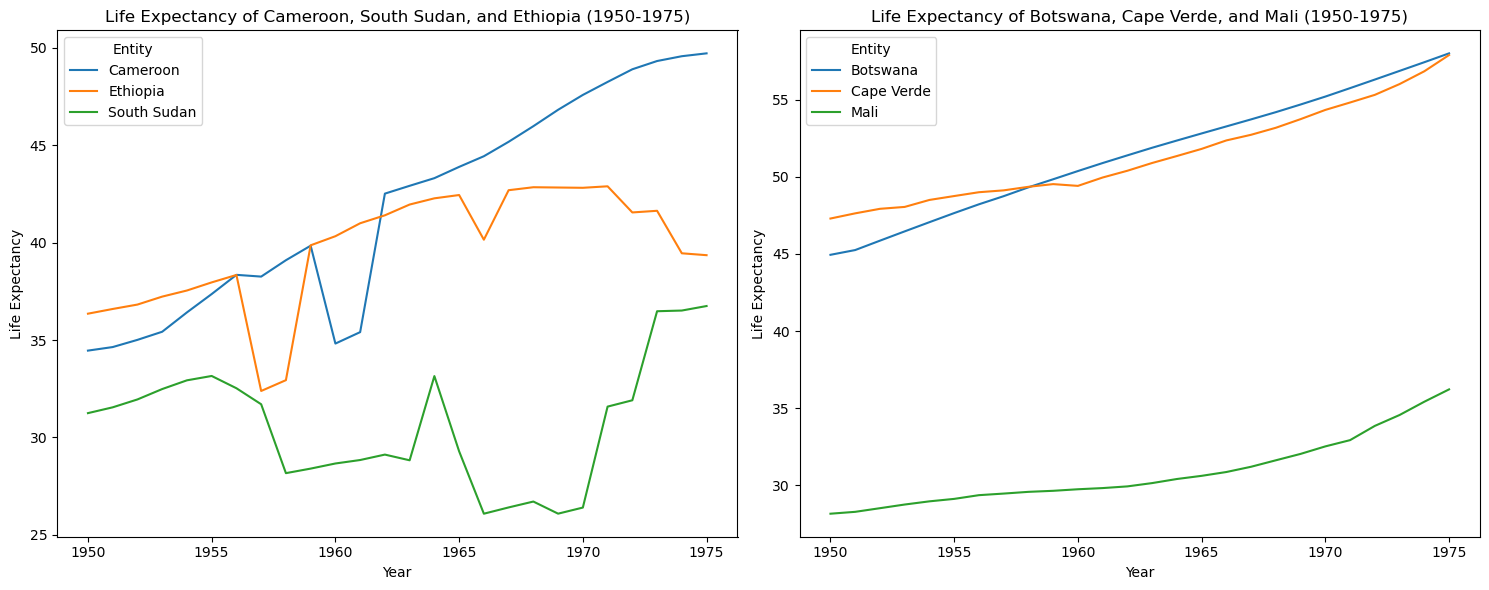

In [95]:
# Filter the data for the selected countries and time period
fluctuate = countries[(countries['Entity'].isin(['Cameroon', 'South Sudan', 'Ethiopia'])) & (countries['Year'] >= 1950) & (countries['Year'] <= 1975)]
smooth = countries[(countries['Entity'].isin(['Botswana', 'Cape Verde', 'Mali'])) & (countries['Year'] >= 1950) & (countries['Year'] <= 1975)]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot the first line graph
sns.lineplot(data=fluctuate, x='Year', y='Period life expectancy at birth - Sex: all - Age: 0', hue='Entity', ax=axes[0])
axes[0].set_title('Life Expectancy of Cameroon, South Sudan, and Ethiopia (1950-1975)')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Life Expectancy')

# Plot the second line graph
sns.lineplot(data=smooth, x='Year', y='Period life expectancy at birth - Sex: all - Age: 0', hue='Entity', ax=axes[1])
axes[1].set_title('Life Expectancy of Botswana, Cape Verde, and Mali (1950-1975)')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Life Expectancy')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

Despite these mixed evolutions of Life Expectancy in individual countries during the era of decolonisation, we can see that it grew significantly overall. It increased by 26% over 25 years, doubling the increase of Europe, Oceania and the Americas in the same period.

In [190]:
# Filter data for the years 1950 and 1975
continents_1950 = continents[continents['Year'] == 1950]
continents_1975 = continents[continents['Year'] == 1975]

# Calculate the percentage change for each continent
result = []
for continent in continents['Entity'].unique():
  life_expectancy_1950 = continents_1950[continents_1950['Entity'] == continent]['Period life expectancy at birth - Sex: all - Age: 0'].values[0]
  life_expectancy_1975 = continents_1975[continents_1975['Entity'] == continent]['Period life expectancy at birth - Sex: all - Age: 0'].values[0]
  percentage_change = ((life_expectancy_1975 - life_expectancy_1950) / life_expectancy_1950) * 100
  result.append({'Continent': continent, 'Percentage Change (1950-1975)': round(percentage_change, 1)})

# Display the results in a DataFrame
pd.DataFrame(result).sort_values(by='Percentage Change (1950-1975)', ascending=False)

Continent  Percentage Change (1950-1975)
2      Asia                           34.9
0    Africa                           24.7
1  Americas                           13.8
3    Europe                           12.3
4   Oceania                           12.0

Then in the 1980's the 'Lost Decade' begun, where quality of life decreased and the continent failed to grow economically as expected. The effects of this lasted well into the 1990's as can be seen below with a relative flattening of Life Expectancy growth throughout the period. We can also see the fluctuations throughout the decolonisation period as some countries struggle to gain their independence. (2)

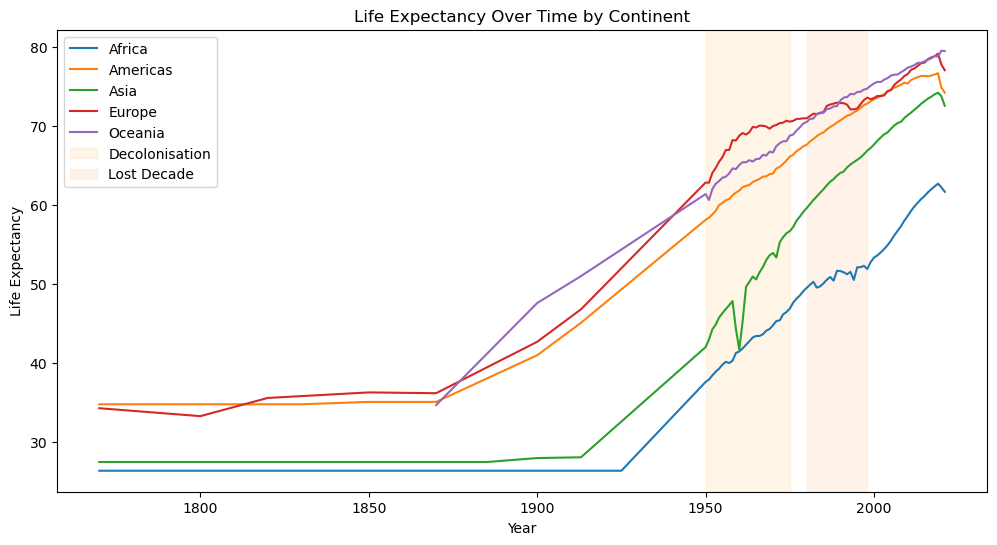

In [111]:
#plotting
plt.figure(figsize=(12, 6))
sns.lineplot(data=continents, x='Year', y='Period life expectancy at birth - Sex: all - Age: 0', hue='Entity')

#highlight the years 1980-1998 and 1950-1975
plt.axvspan(1950, 1975, color='navajowhite', alpha=0.3, label='Decolonisation')
plt.axvspan(1980, 1998, color='peachpuff', alpha=0.3, label='Lost Decade')

plt.title('Life Expectancy Over Time by Continent')
plt.xlabel('Year')
plt.ylabel('Life Expectancy')
plt.legend()
plt.show()

As would be expected, the percentage change throughout the 'Lost Decade' was reduce greatly, having only increased by 4% in the 18 year period.

In [188]:
# filter data for the years 1980 and 1998
continents_1980 = continents[continents['Year'] == 1980]
continents_1998 = continents[continents['Year'] == 1998]

# calculate the percentage change for each continent
result = []
for continent in continents['Entity'].unique():
  life_expectancy_1980 = continents_1980[continents_1980['Entity'] == continent]['Period life expectancy at birth - Sex: all - Age: 0'].values[0]
  life_expectancy_1998 = continents_1998[continents_1998['Entity'] == continent]['Period life expectancy at birth - Sex: all - Age: 0'].values[0]
  percentage_change = ((life_expectancy_1998 - life_expectancy_1980) / life_expectancy_1980) * 100
  result.append({'Continent': continent, 'Percentage Change (1980-1998)': round(percentage_change, 1)})
    
# display the results in a df
pd.DataFrame(result).sort_values(by='Percentage Change (1980-1998)', ascending=False)

Continent  Percentage Change (1980-1998)
2      Asia                           12.2
1  Americas                            7.7
4   Oceania                            6.0
0    Africa                            4.8
3    Europe                            3.7

To sum, Africa's medical infrastructure was sparse for much of its colonial occupation, with an increase towards the end of the era. Then in the 1950's, the decolonisation process differed across countries, leading to fluctuations throughout the period but ultimately an impressive increase of 24% in Life Expectancy. Finally, from the 1980's to 1990's Life Expectancy flatlines and only increases 4% in 18 years as the 'Lost Decade' brings lows in li

#### ***Sources***
1. https://www.tandfonline.com/doi/full/10.1080/20780389.2023.2209284
2. https://muse.jhu.edu/pub/127/article/558356/pdf

## Mortality Analysis

### ***Mortality Analysis***

Now that we have a broader understanding of how Africa's Life Expectancy grew historically, we can look into specific causes impacting Life Expectancy, that may partially explain the current gap between Life Expectancy in Africa compared to the rest of the world.

When looking at the causes of mortality in Africa compared the rest of the world, we can see that Africa consistently has higher mortality rates. From the 230 causes of mortality examined, Africa had a higher mortality rate in 70% of them. To illustrate, the below shows the difference between the mortality rate per 100,000 people in Africa compared to the global average. The largest square will represent the largest difference in mortality rate and the colour will indicate if it is a positive difference (e.g. a red square of size 79 will mean that 79 more people per 100,000 will die from this cause in Africa than globally, a green square would represent that 79 less people will die from this cause in Africa than globally).

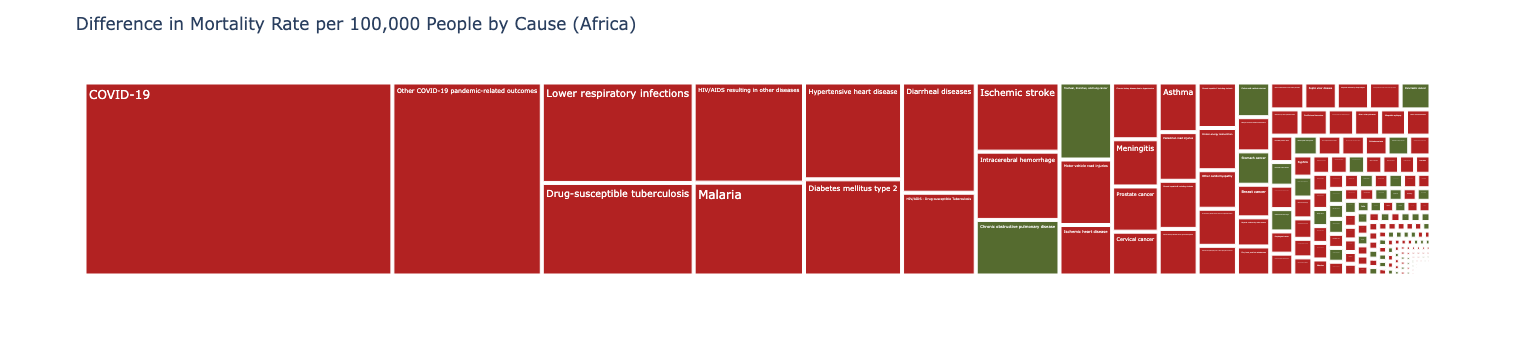

In [133]:
#negatives
africa_group['diff_abs'] = africa_group['diff'].abs()
africa_group['color'] = np.where(africa_group['diff'] < 0, 'Negative', 'Positive')

#plotting
fig = px.treemap(africa_group, path=['cause_name'], values='diff_abs', color='color',
                 color_discrete_map={'Positive':'firebrick', 'Negative':'darkolivegreen'},
                 hover_data={'cause_name': True, 'diff_abs': True})  # Include hover data

#fix tooltips
fig.update_traces(hovertemplate='<b>Mortality Cause: %{customdata[0]}</b><br>Difference from Global Mortality Rate: %{customdata[1]:.2f}')

fig.update_layout(title='Difference in Mortality Rate per 100,000 People by Cause (Africa)')
fig.show()

Given that Africa suffers from a majority of mortality causes at a higher rate than globally, we can look at how different categories have contributed to Life Expectancy from the period starting in 1990 and ending in 2021.

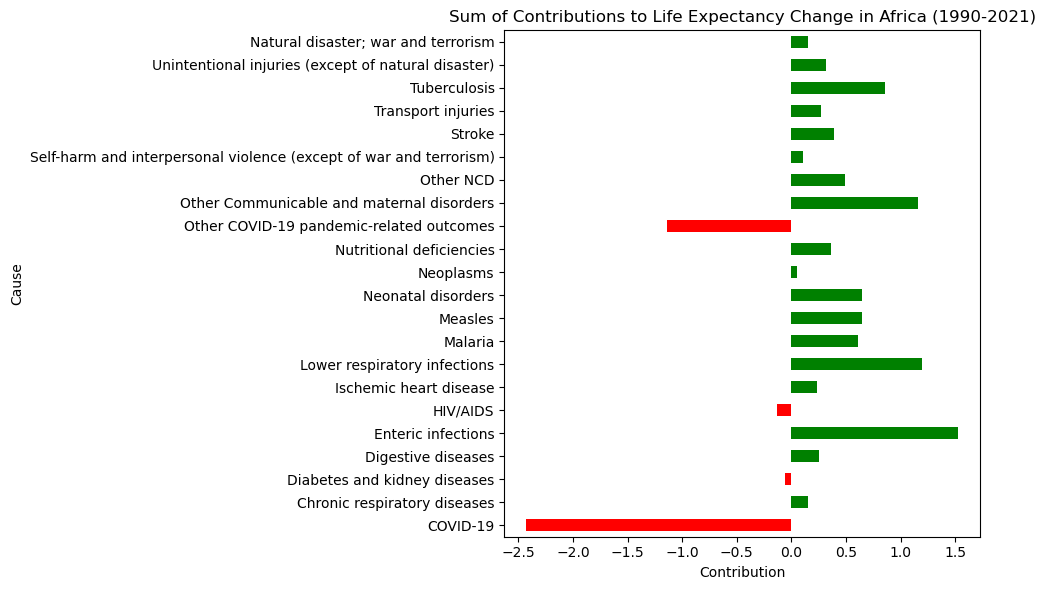

In [138]:
columns_to_avg = decomp_africa.columns[5:]
decomp_africa_avg = decomp_africa[columns_to_avg].mean()

#plotting
plt.figure(figsize=(10, 6))
colors = ['red' if v < 0 else 'green' for v in decomp_africa_sum.values]
decomp_africa_avg.plot(kind='barh', color=colors)
plt.title('Sum of Contributions to Life Expectancy Change in Africa (1990-2021)')
plt.ylabel('Cause')
plt.xlabel('Contribution')
plt.tight_layout()
plt.show()

We can see that throughout this period, there have been mainly positive trends in most diseases. We can interpret that while the mortality rate of these causes are still comparatively very high as per the first figure, gradual improvements are made on most causes, helping to slowly close the mortality gap between Africa and the rest of the world. However, strikingly, pandemics are the most impactful on Life Expectancy. Covid-19 and its related outcomes lost an average of around 3.5 years of Life Expectancy, with HIV/AIDs contributing the second most. 

Looking to the leading mortality rates in Africa, in both 2010 and 2021, the cause with the highest mortality rate was a pandemic (HIV/AIDs and COVID-19 respectively), that was suffered much worse than the global average. If mortality rates for causes with known cures or treatments are already high, it follows that responding to a new cause with no clear treatment and high contagiousness will shock medical infrastructures and ultimately impact Life Expectancy moreso than their counterparts.

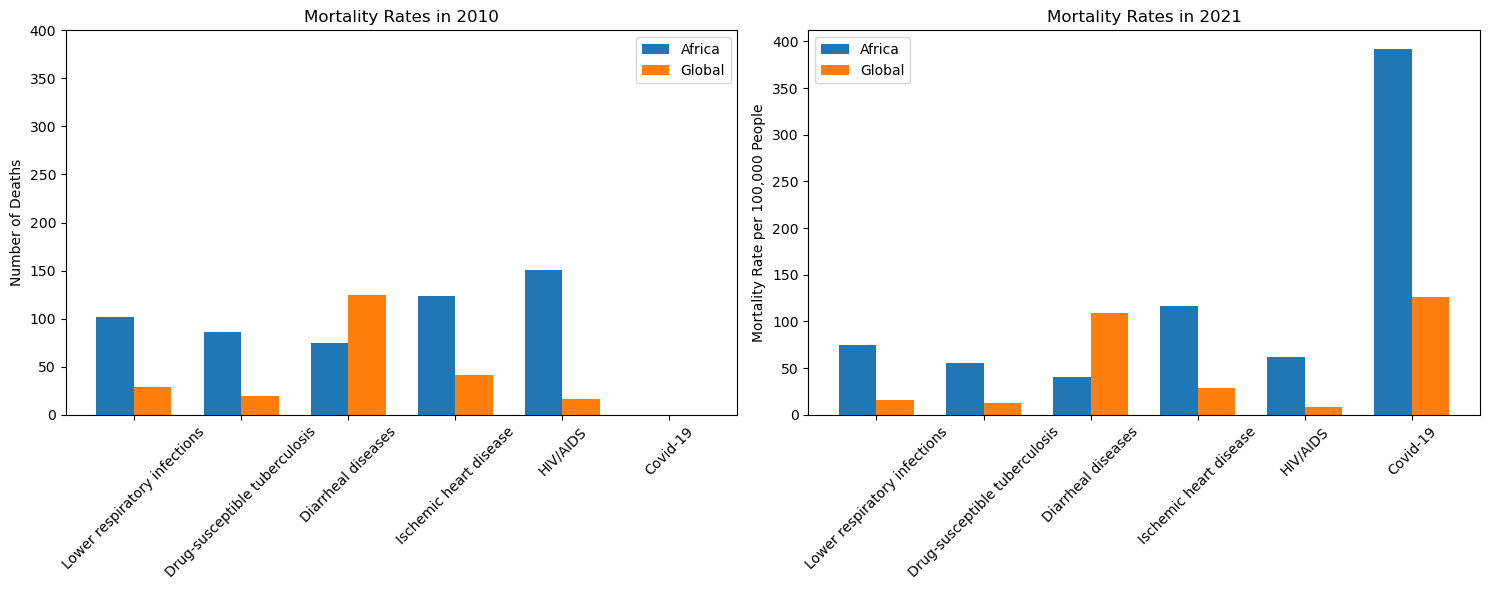

In [143]:
#grouping together different categories of disease
hiv = ['HIV/AIDS - Drug-susceptible Tuberculosis', 'HIV/AIDS - Extensively drug-resistant Tuberculosis', 'HIV/AIDS - Multidrug-resistant Tuberculosis without extensive drug resistance', 'HIV/AIDS resulting in other diseases', 'Maternal deaths aggravated by HIV/AIDS']
covid = ['COVID-19', 'Other COVID-19 pandemic-related outcomes']

a_hiv_df = africa_group[africa_group['cause_name'].isin(hiv)]
a_covid_df = africa_group[africa_group['cause_name'].isin(covid)]

g_hiv_df = globe_group[globe_group['cause_name'].isin(hiv)]
g_covid_df = globe_group[globe_group['cause_name'].isin(covid)]

#add to main dfs
a_hiv = {'cause_name': 'HIV/AIDS', '2010 (ASMR)': a_hiv_df['2010 (ASMR)'].sum(), '2019 (ASMR)': a_hiv_df['2019 (ASMR)'].sum(), '2020 (ASMR)': a_hiv_df['2020 (ASMR)'].sum(), '2021 (ASMR)': a_hiv_df['2021 (ASMR)'].sum()}
a_covid = {'cause_name': 'Covid-19', '2010 (ASMR)': a_covid_df['2010 (ASMR)'].sum(), '2019 (ASMR)': a_covid_df['2019 (ASMR)'].sum(), '2020 (ASMR)': a_covid_df['2020 (ASMR)'].sum(), '2021 (ASMR)': a_covid_df['2021 (ASMR)'].sum()}
g_hiv = {'cause_name': 'HIV/AIDS', '2010 (ASMR)': g_hiv_df['2010 (ASMR)'].sum(), '2019 (ASMR)': g_hiv_df['2019 (ASMR)'].sum(), '2020 (ASMR)': g_hiv_df['2020 (ASMR)'].sum(), '2021 (ASMR)': g_hiv_df['2021 (ASMR)'].sum()}
g_covid = {'cause_name': 'Covid-19', '2010 (ASMR)': g_covid_df['2010 (ASMR)'].sum(), '2019 (ASMR)': g_covid_df['2019 (ASMR)'].sum(), '2020 (ASMR)': g_covid_df['2020 (ASMR)'].sum(), '2021 (ASMR)': g_covid_df['2021 (ASMR)'].sum()}

africa_group.loc[231] = a_hiv
africa_group.loc[232] = a_covid
globe_group.loc[231] = g_hiv
globe_group.loc[232] = g_covid

top_causes = ['HIV/AIDS', 'Covid-19', 'Ischemic heart disease', 'Lower respiratory infections', 'Drug-susceptible tuberculosis', 'Diarrheal diseases']

#filter for 2010 and 2021
africa_2010 = africa_group[africa_group['cause_name'].isin(top_causes)]
global_2010 = globe_group[globe_group['cause_name'].isin(top_causes)]
africa_2021 = africa_group[africa_group['cause_name'].isin(top_causes)]
global_2021 = globe_group[globe_group['cause_name'].isin(top_causes)]                                                       
                                                            
#subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

#plotting for 2010
bar_width = 0.35
index = np.arange(len(africa_2010['cause_name']))
axes[0].bar(index, africa_2010['2010 (ASMR)'], bar_width, label='Africa')
axes[0].bar(index + bar_width, global_2010['2010 (ASMR)'], bar_width, label='Global')
axes[0].set_title('Mortality Rates in 2010')
axes[0].set_ylabel('Number of Deaths')
axes[0].set_ylim(0, 400)
axes[0].set_xticks(index + bar_width / 2)
axes[0].set_xticklabels(africa_2010['cause_name'], rotation=45)
axes[0].legend()

#plotting for 2021
axes[1].bar(index, africa_2021['2021 (ASMR)'], bar_width, label='Africa')
axes[1].bar(index + bar_width, global_2021['2021 (ASMR)'], bar_width, label='Global')
axes[1].set_title('Mortality Rates in 2021')
axes[1].set_ylabel('Mortality Rate per 100,000 People')
axes[1].set_xticks(index + bar_width / 2)
axes[1].set_xticklabels(africa_2021['cause_name'], rotation=45)
axes[1].legend()

#layout
plt.tight_layout()
plt.show()

In short, Africa has higher mortality rates in a majority of causes than the global average, but their overall Life Expectancy is most vulnerable to pandemics with COVID-19 and HIV contributing the most negative gains in Life Expectancy from 1990 to 2021. It follows too that Africa will experience the impact of pandemics far worse than their global counterparts, with almost triple the mortality rate of Covid-19 in 2021 and nearly 10 times the mortality rate of HIV/AIDs in 2010. 

## Contemporary Context

#### ***Contemporary Context***

To provide some context for why mortality is higher in Africa as opposed to the rest of the globe, the below visualisations of key factors have been created.

***1. Deaths in Conflict by Continent***

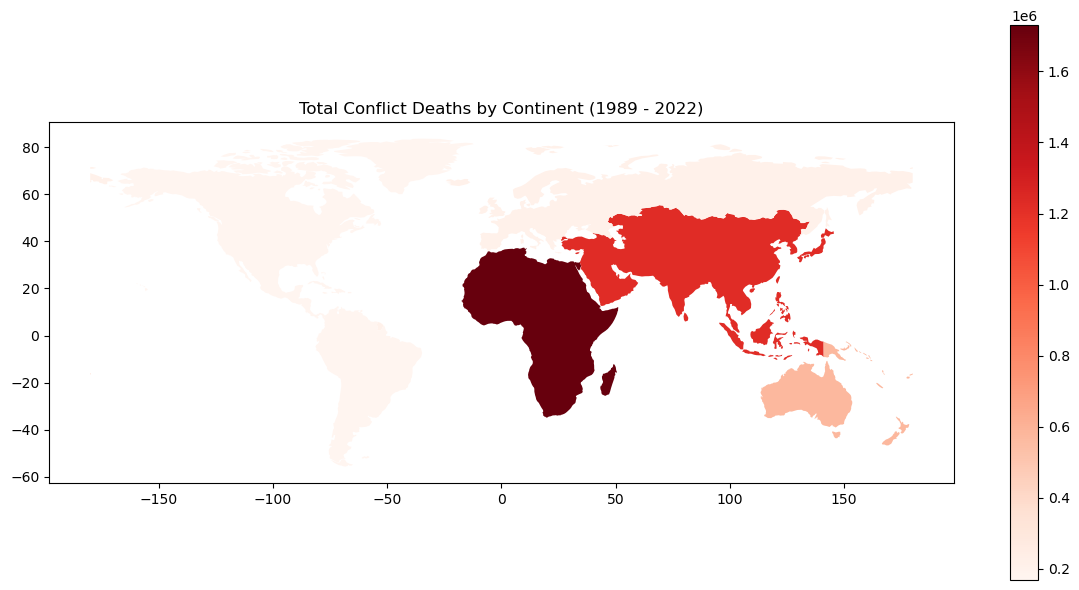

In [192]:
#world map data
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

#update total deaths per continent (match data continents with gpd continents)
conflict_continents = conflict.groupby('Entity')['Deaths in ongoing conflicts (best estimate) - Conflict type: all'].sum().reset_index()
na = {'Entity': 'North America', 'Deaths in ongoing conflicts (best estimate) - Conflict type: all': 168048}
sa = {'Entity': 'South America', 'Deaths in ongoing conflicts (best estimate) - Conflict type: all': 168048}
a = {'Entity': 'Asia', 'Deaths in ongoing conflicts (best estimate) - Conflict type: all': 571516 + 653621}
o = {'Entity': 'Oceania', 'Deaths in ongoing conflicts (best estimate) - Conflict type: all': 571516}
conflict_continents.loc[6] = na
conflict_continents.loc[7] = sa
conflict_continents.loc[8] = a
conflict_continents.loc[9] = o
conflict_continents = conflict_continents[conflict_continents['Entity'].isin(world['continent'].unique()) == True]

#update geodf for continents
continent_data = {
    'Continent': ['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America'],
    'geometry': [
        world[world['continent'] == 'Africa']['geometry'].unary_union,
        world[world['continent'] == 'Asia']['geometry'].unary_union,
        world[world['continent'] == 'Europe']['geometry'].unary_union,
        world[world['continent'] == 'North America']['geometry'].unary_union,
        world[world['continent'] == 'Oceania']['geometry'].unary_union,
        world[world['continent'] == 'South America']['geometry'].unary_union
    ]
}
continent_gdf = gpd.GeoDataFrame(continent_data, crs=world.crs)


conflict_continents.columns = ['Continent', 'Deaths in ongoing conflicts (best estimate) - Conflict type: all']

#merge
continent_conflicts = continent_gdf.merge(conflict_continents, on='Continent', how='left')

#plotting
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
continent_conflicts.plot(column='Deaths in ongoing conflicts (best estimate) - Conflict type: all', cmap='Reds', legend=True, ax=ax, missing_kwds={'color': 'lightgrey'})
ax.set_title('Total Conflict Deaths by Continent (1989 - 2022)')
plt.tight_layout()
plt.show()


*Limitation: The data source categorises some continents together (i.e. Oceania and Asia, North America and South America) so some numbers may be misleading. For example, Australia likely has a lower amount of conflict deaths than is shown, however, regardless of how continents are categorised, Africa still leads in conflict deaths.*

***2. GDP by Country***

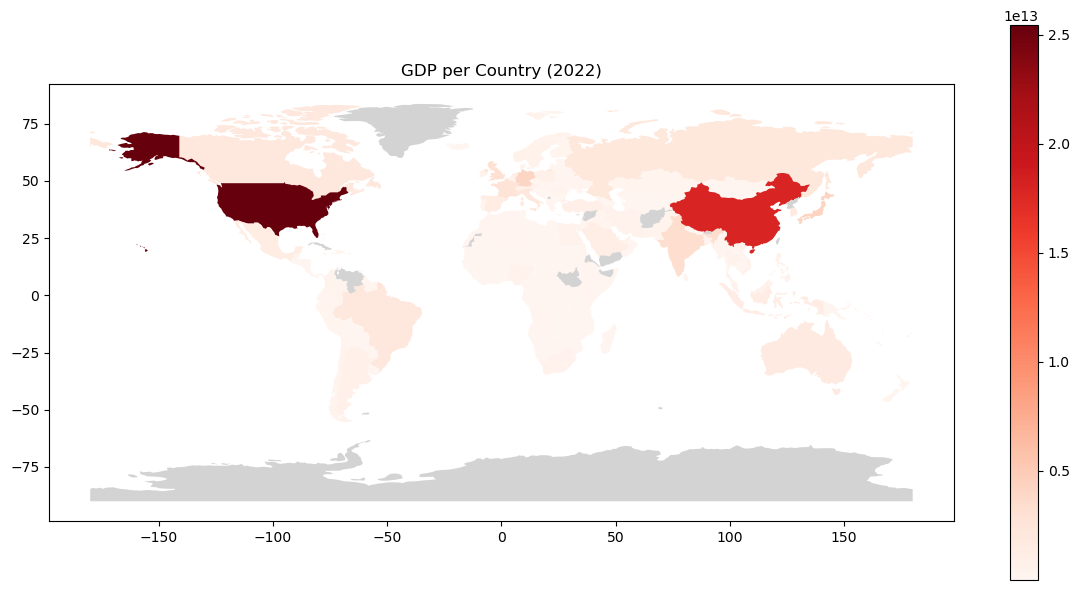

In [164]:
#world map data
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

#merge
world_gdp = world.merge(gdp, left_on='iso_a3', right_on='iso_a3', how='left')

#plotting
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
world_gdp.plot(column='GDP 2022', cmap='Reds', legend=True, ax=ax, missing_kwds={'color': 'lightgrey'})
ax.set_title('GDP per Country (2022)')
plt.tight_layout()
plt.show()

***3. Health Expenditure as a Percent of GDP (2000 vs 2021)***

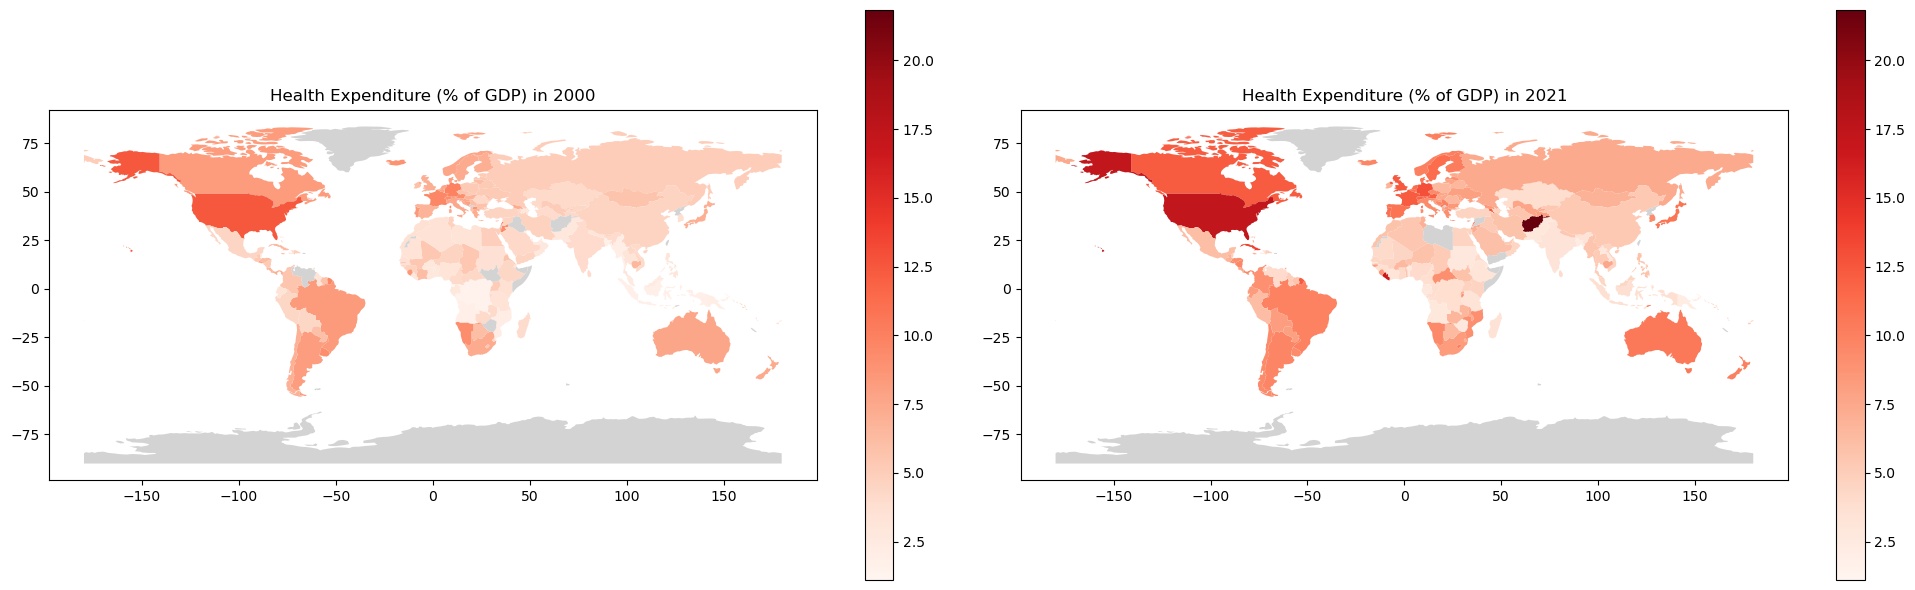

In [169]:
#world map data
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

#get data for 2000 and 2021
expense_2000 = expense[['Country Code', '2000']].dropna()
expense_2021 = expense[['Country Code', '2021']].dropna()

#merge
world_expense_2000 = world.merge(expense_2000, left_on='iso_a3', right_on='Country Code', how='left')
world_expense_2021 = world.merge(expense_2021, left_on='iso_a3', right_on='Country Code', how='left')

#subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

#match scales
vmin = min(world_expense_2000['2000'].min(), world_expense_2021['2021'].min())
vmax = max(world_expense_2000['2000'].max(), world_expense_2021['2021'].max())

#plotting 2000
world_expense_2000.plot(column='2000', cmap='Reds', legend=True, ax=axes[0], missing_kwds={'color': 'lightgrey'}, vmin=vmin, vmax=vmax)
axes[0].set_title('Health Expenditure (% of GDP) in 2000')

#plotting 2021
world_expense_2021.plot(column='2021', cmap='Reds', legend=True, ax=axes[1], missing_kwds={'color': 'lightgrey'}, vmin=vmin, vmax=vmax)
axes[1].set_title('Health Expenditure (% of GDP) in 2021')

#layout
plt.tight_layout()
plt.show()


## Conclusion

### ***Conclusion***

To summarise this report, we can explain why Africa's Life Expectancy began rising so much later than other nations, how it rose historically, and the contemporary reasons for the current gap between Africa's Life Expectancy and that of other continents through the following:

1. Africa was largely under colonial rule until the 1950's and medical infrastructure was limited, and there was limited accessibility for Indigenous people. Even as medical infrastructure expanded in the 19th century, it was still limited comparatively, particularly for Indigenous citizens.
2. Around the 1950's, decolonisation began with varied results across countries. There was lots of fluctuation in life expectancy, but ultimately it rose 24% in a 25 year period.
3. In the 1980's and 1990's the effects of the 'Lost Decade' halt gains in life expectancy, with strong fluctuations and a mere 4% rise in 18 years.
4. In a contemporary context, Africa has higher mortality rates for 70% of causes than the global average and is affected the most significantly by pandemics, both in terms of life expectancy, and comparative to the global average.
5. Some factors that may influence this include that Africa has the highest amount of deaths in combat of all continents from 1989 to 2022, African countries have significantly lower comparative GDPs and their health expenditure by GDP is also typically lower than other continents.